In [1]:
import cv2
import numpy as np
import glob
import pandas as pd

import math
import scipy
from scipy.spatial import distance
from scipy import signal
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
from sklearn import metrics
import copy

In [2]:
#  !pip install unrar
#  !unrar x CASIA.rar

In [3]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [4]:
def compute_dis(test_feature, target_feature, norm):
  if norm == 1:
    return np.sum(np.abs(test_feature-target_feature))
  elif norm == 2:
    return np.sum(np.square(test_feature-target_feature))
  else:
    return 1-np.dot(test_feature,target_feature.T)/(np.linalg.norm(test_feature)*np.linalg.norm(target_feature))

In [5]:
def get_class(p, df_train, label):
  train_templates = df_train[label].values
  dis_1 = list(map(lambda x: compute_dis(p[label], x, 1),train_templates))
  dis_2 = list(map(lambda x: compute_dis(p[label], x, 2),train_templates))
  dis_cos = list(map(lambda x: compute_dis(p[label], x, 3),train_templates))
  min_idx_1 = np.argmin(dis_1)
  min_idx_2 = np.argmin(dis_2)
  min_idx_cos = np.argmin(dis_cos)

  p['class_1'] = list(df_train['idx'].values)[min_idx_1]
  p['class_2'] = list(df_train['idx'].values)[min_idx_2]
  p['cos_sim'] = min(dis_cos)[0][0]
  p['class_cos'] = list(df_train['idx'].values)[min_idx_cos]
  return p

In [6]:
from IrisLocalization import IrisLocalization
from IrisNormalization import IrisNormalization
from ImageEnhancement import ImageEnhancement
from FeatureExtraction import FeatureExtraction
# from IrisMatching import IrisMatching
# from PerformanceEvaluation import PerformanceEvaluation

In [7]:
images_train = [cv2.imread(file) for file in sorted(glob.glob('CASIA Iris Image Database (version 1.0)/*/1/*.bmp'))]
#running Localization, Normalization,Enhancement and Feature Extraction on all the training images
boundary_train,centers_train=IrisLocalization(images_train)
normalized_train=IrisNormalization(boundary_train,centers_train, True)
# rotate_train = sum(list(map(lambda p: getRotation(p, [-9,-6,-3,0,3,6,9]), normalized_train.copy())), [])
enhanced_train=ImageEnhancement(normalized_train)
feature_vector_train=FeatureExtraction(enhanced_train)
print("Training data processed.")

'''TESTING'''

#reading the testing images from the CASIA dataset
images_test = [cv2.imread(file) for file in sorted(glob.glob('CASIA Iris Image Database (version 1.0)/*/2/*.bmp'))]

#running Localization, Normalization,Enhancement and Feature Extraction on all the testing images
boundary_test,centers_test=IrisLocalization(images_test)
normalized_test=IrisNormalization(boundary_test,centers_test, False)
enhanced_test=ImageEnhancement(normalized_test)
feature_vector_test=FeatureExtraction(enhanced_test)
print("Testing data processed.")

/Users/fred/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/fred/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Training data processed.
Testing data processed.


In [8]:
sliced_res_train = list(chunks(feature_vector_train,21))

list_of_dataframes_train = []
for i, eyes in enumerate(sliced_res_train):
# i from 0 to 107
    sliced_eyes = list(chunks(eyes,7))
    for j, eye in enumerate(sliced_eyes):
        # j from 0 to 3
        degree = [-9,-6,-3,0,3,6,9]
        img_idx = [j]*7
        idx = [i]*7
        df_tmp = pd.DataFrame({'idx':idx, 'img_idx':img_idx, 'degree':degree, 'feature': eye })
        list_of_dataframes_train.append(df_tmp)
df_train = pd.concat(list_of_dataframes_train)

In [9]:
sliced_res_test = list(chunks(feature_vector_test,4))

list_of_dataframes_test = []
for i, eyes in enumerate(sliced_res_test):
# i from 0 to 107
    for j, eye in enumerate(eyes):
        # j from 0 to 3
        img_idx = [j]
        idx = [i]
        df_tmp = pd.DataFrame({'idx':idx, 'img_idx':img_idx, 'feature':[np.array(eye)]})
        list_of_dataframes_test.append(df_tmp)
      
df_test = pd.concat(list_of_dataframes_test)

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [11]:
clf = LDA(n_components=100)
clf.fit(list(df_train['feature'].values), list(df_train['idx'].values))
df_train['reduced_feature']=df_train['feature'].apply(lambda x: clf.transform(np.array(x).reshape(1, -1)))
df_test['reduced_feature']=df_test['feature'].apply(lambda x: clf.transform(np.array(x).reshape(1, -1)))

In [12]:
def get_crr(class_lab1,class_lab2,class_lab3,target_lab):
    crr_1 = sum(target_lab==class_lab1)/len(target_lab) * 100
    crr_2 = sum(target_lab==class_lab2)/len(target_lab) * 100
    crr_3 = sum(target_lab==class_lab3)/len(target_lab) * 100
    return crr_1,crr_2,crr_3

In [14]:
# n_component = range(40,101,10)
# L1_crr = []
# L2_crr = []
# cos_crr = []
# df_dic = {}
# for i in range(len(n_component)):
#     clf = LDA(n_components=n_component[i])
#     clf.fit(list(df_train['feature'].values), list(df_train['idx'].values))
#     df_train['reduced_feature']=df_train['feature'].apply(lambda x: clf.transform(np.array(x).reshape(1, -1)))
#     df_test['reduced_feature']=df_test['feature'].apply(lambda x: clf.transform(np.array(x).reshape(1, -1)))
#
#     # Class labels using L1,L2, and Cosine Similarity measures
#     df_test = df_test.apply(lambda x: get_class(x, df_train.copy(), 'reduced_feature'), axis=1)
#     # df_test = df_test.apply(lambda x: get_class(x, df_train.copy(), 'reduced_feature', 2), axis=1)
#     # df_test = df_test.apply(lambda x: get_class(x, df_train.copy(), 'reduced_feature', 3), axis=1)
#
#     crr_1,crr_2,crr_3 = get_crr(df_test['class_1'],df_test['class_2'],df_test['class_cos'],df_test['idx'])
#     L1_crr.append(crr_1)
#     L2_crr.append(crr_2)
#     cos_crr.append(crr_3)
#
#     df_dic[n_component[i]] = df_test


In [15]:
L1_crr = []
L2_crr = []
cos_crr = []
df_dic = {}
clf = LDA(n_components=100)
clf.fit(list(df_train['feature'].values), list(df_train['idx'].values))
df_train['reduced_feature']=df_train['feature'].apply(lambda x: clf.transform(np.array(x).reshape(1, -1)))
df_test['reduced_feature']=df_test['feature'].apply(lambda x: clf.transform(np.array(x).reshape(1, -1)))

# Class labels using L1,L2, and Cosine Similarity measures
df_test = df_test.apply(lambda x: get_class(x, df_train.copy(), 'reduced_feature'), axis=1)
# df_test = df_test.apply(lambda x: get_class(x, df_train.copy(), 'reduced_feature', 2), axis=1)
# df_test = df_test.apply(lambda x: get_class(x, df_train.copy(), 'reduced_feature', 3), axis=1)

crr_1,crr_2,crr_3 = get_crr(df_test['class_1'],df_test['class_2'],df_test['class_cos'],df_test['idx'])
L1_crr.append(crr_1)
L2_crr.append(crr_2)
cos_crr.append(crr_3)

df_dic[100] = df_test

In [16]:
df_test.head()

,idx,img_idx,feature,reduced_feature,class_1,class_2,cos_sim,class_cos
0,0,0,"[2.6933103933794538, 1.5867874645006035, 2.454...","[[4.053142889279266, 3.3744120965820117, 7.995...",0,0,0.596643,0
0,0,1,"[2.6160163952741815, 1.699530664977702, 2.3753...","[[-18.632908508187832, -15.2773042183355, -17....",0,0,0.513458,0
0,0,2,"[2.657925630714464, 1.7006351415568206, 2.4048...","[[-12.404171762906278, -5.246513429669791, -13...",49,0,0.642057,0
0,0,3,"[2.6893647728642973, 1.601359019915468, 2.4632...","[[-8.803856171017781, -1.5303744768311547, -16...",0,0,0.358244,0
0,1,0,"[2.6230213611863418, 1.5136382692433439, 2.390...","[[12.64201467022057, -9.861742074793032, -4.71...",1,1,0.547586,1


In [ ]:
# plt.plot(n_component,L1_crr,label='L1')
# plt.plot(n_component,L2_crr,label='L2')
# plt.plot(n_component,cos_crr,label='Cosine')

# plt.legend(loc = 'upper left')
# plt.xlabel("Dimensionality of the Feature Vector")
# plt.ylabel('Correct Recognition Rate')
# plt.title('Dimensionality vs. CRR')
# plt.show()

In [18]:
# Using feature number = 100 would perform the best result
# clf = LDA(n_components=100)
# clf.fit(list(df_train['feature'].values), list(df_train['idx'].values))
# df_train['reduced_feature']=df_train['feature'].apply(lambda x: clf.transform(np.array(x).reshape(1, -1)))
# df_test['reduced_feature']=df_test['feature'].apply(lambda x: clf.transform(np.array(x).reshape(1, -1)))

# # Class labels through L1,L2, and Cosine Similarity measures
# class1 = df_test['reduced_feature'].apply(lambda x: get_class(df_train.copy(), x, 'reduced_feature', 1))
# class2 = df_test['reduced_feature'].apply(lambda x: get_class(df_train.copy(), x, 'reduced_feature', 2))
# cos_sim, class3 = df_test['reduced_feature'].apply(lambda x: get_class(df_train.copy(), x, 'reduced_feature', 3))

df_result = df_dic[100]
class1, class2, cos_sim, class_cos = df_result['class_1'].values, df_result['class_2'].values, df_result['cos_sim'].values, df_result['class_cos'].values

In [19]:
crr_rates = list(get_crr(class1,class2,class_cos,df_test['idx']))

In [20]:
print('\n\n')
dict={'Similarity Measure':['L1 distance measure','L2 distance measure','Cosine similarity measure'],'Reduced Feature Set':[crr_rates[0],crr_rates[1],crr_rates[2]]}
table=pd.DataFrame(dict)
print ("Correct recognition rate (%):")
table




Correct recognition rate (%):


,Similarity Measure,Reduced Feature Set
0,L1 distance measure,68.981481
1,L2 distance measure,71.527778
2,Cosine similarity measure,73.611111


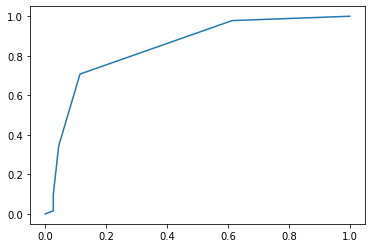

In [21]:
def test_match(threshold, x):
  if x['cos_sim']<=threshold:
    return 1
  else:
    return 0

def ROC(threshold, df):
  df['match'] = df.apply(lambda x: test_match(threshold, x), axis=1)
  n = df.shape[0]
  positive = df[df['idx']==df['class_cos']].shape[0]
  negative = n - positive
  tp = df[(df['match']==1)&(df['idx']==df['class_cos'])].shape[0]
  fp = df[(df['match']==1)&(df['idx']!=df['class_cos'])].shape[0]
  fn = df[(df['match']==0)&(df['idx']==df['class_cos'])].shape[0]

  fpr = fp/negative
  fnr = fn/positive
  tpr = tp/(tp+fn)

  return fpr, tpr


fpr_res = []
tpr_res = []
for threshold in np.linspace(0,1,10):
  fpr, tpr = ROC(threshold, df_test)
  fpr_res.append(fpr)
  tpr_res.append(tpr)

plt.plot(fpr_res, tpr_res)